In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import EfficientNetImageProcessor, EfficientNetForImageClassification, get_scheduler
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns

# Check and create output directory
if not os.path.exists('./outputs'):
    os.mkdir('./outputs')

/home/dungtran/anaconda3/envs/EfficientViT-Microsoft/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Global parameters
USE_CUDA = torch.cuda.is_available()
DATASET_PATH = '/home/MATLAB_DATA/TiNguyen/Sentry_Data_EsN0db_SNR_4db'   #'C:\\Users\\thanh-dung.le\\Documents\\EuroSat_Satellite\\EuroSAT_RGB'
BATCH_SIZE = 64
NUM_EPOCHS = 25
LEARNING_RATE = 0.001
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005

In [3]:

# Check train and test directories
train_path = os.path.join(DATASET_PATH, 'train')
print(f"Train directory exists: {os.path.exists(train_path)}")
print(f"Classes in train directory: {os.listdir(train_path)}")
test_path = os.path.join(DATASET_PATH, 'test')
print(f"Test directory exists: {os.path.exists(test_path)}")
print(f"Classes in test directory: {os.listdir(test_path)}")

# Data transformations
data_transforms = transforms.Compose([
    transforms.Resize(224),  # Resizing to 256 as required by EfficientNet
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Datasets and DataLoaders
train_dataset = datasets.ImageFolder(os.path.join(DATASET_PATH, 'train'), data_transforms)
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_dataset = datasets.ImageFolder(os.path.join(DATASET_PATH, 'test'), data_transforms)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
class_names = train_dataset.classes

print('Dataloaders OK')

Train directory exists: True
Classes in train directory: ['Residential', 'AnnualCrop', 'SeaLake', 'Highway', 'River', 'PermanentCrop', 'Pasture', 'Industrial', 'HerbaceousVegetation', 'Forest']
Test directory exists: True
Classes in test directory: ['Residential', 'AnnualCrop', 'SeaLake', 'Highway', 'River', 'PermanentCrop', 'Pasture', 'Industrial', 'HerbaceousVegetation', 'Forest']
Dataloaders OK


Image label: 6


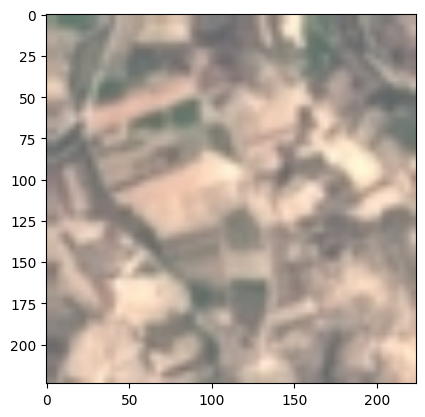

In [4]:
# Example data point visualization
random_image = train_dataset[13421][0].numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
random_image = std * random_image + mean
random_image = np.clip(random_image, 0, 1)
print("Image label:", train_dataset[13421][1])
plt.imshow(random_image)
plt.show()

In [5]:
# Load pre-trained model (Google)
from classification.model.build import EfficientViT_M2
model = EfficientViT_M2(pretrained='efficientvit_m2')

# Modify the classifier to match the number of classes
model.head.l = nn.Linear(model.head.l.in_features, len(class_names))


if USE_CUDA:
    model = model.cuda()

print('Network OK')

Network OK


In [6]:
# Simplified summary printing function
def print_model_summary(model):
    print(model)
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("\nTotal parameters:", total_params)
    print("Trainable parameters:", trainable_params)
    print("Non-trainable parameters:", total_params - trainable_params)

In [7]:
from torchsummary import summary
from collections import OrderedDict
print_model_summary(model)

EfficientViT(
  (patch_embed): Sequential(
    (0): Conv2d_BN(
      (c): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ReLU()
    (2): Conv2d_BN(
      (c): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): ReLU()
    (4): Conv2d_BN(
      (c): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): ReLU()
    (6): Conv2d_BN(
      (c): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (blocks1): Sequential(
    (0): EfficientViTBlock(
      (dw0): Residual(


In [8]:
# Criterion, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), eps=1e-08, weight_decay=WEIGHT_DECAY)
#optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
#scheduler = get_scheduler("step", optimizer=optimizer, step_size=7, gamma=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)



Running epoch 1 of 25...


Epoch 1 validation results: Loss=0.8934655975748411 | Accuracy=79.82694684796044


Total Training Time: 16.06610655784607 seconds
Total Inference Time: 6.410995721817017 seconds


Running epoch 2 of 25...


Epoch 2 validation results: Loss=0.15364409624378922 | Accuracy=95.45117428924598


Total Training Time: 29.53846526145935 seconds
Total Inference Time: 12.82333755493164 seconds


Running epoch 3 of 25...


Epoch 3 validation results: Loss=0.15136955483765233 | Accuracy=95.73547589616811


Total Training Time: 43.170872926712036 seconds
Total Inference Time: 19.278873205184937 seconds


Running epoch 4 of 25...


Epoch 4 validation results: Loss=0.12640804206351125 | Accuracy=96.39060568603213


Total Training Time: 59.03619885444641 seconds
Total Inference Time: 25.62758231163025 seconds


Running epoch 5 of 25...


Epoch 5 validation results: Loss=0.19960598399363985 | Accuracy=93.8195302843016


Total Training Time: 72.82142043113708 seconds
Total In

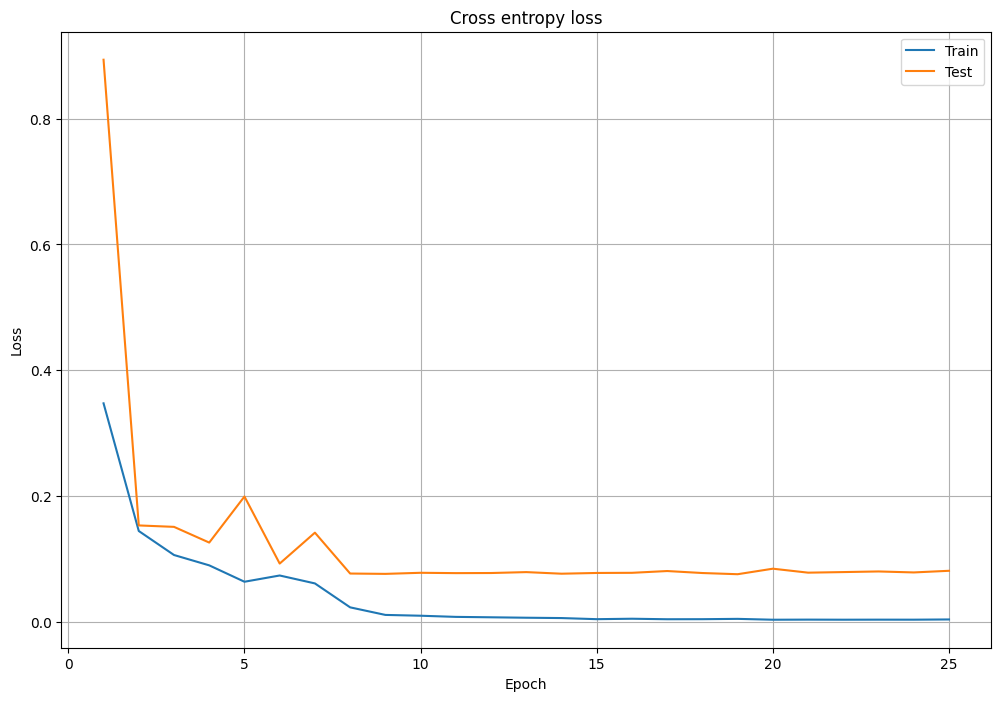

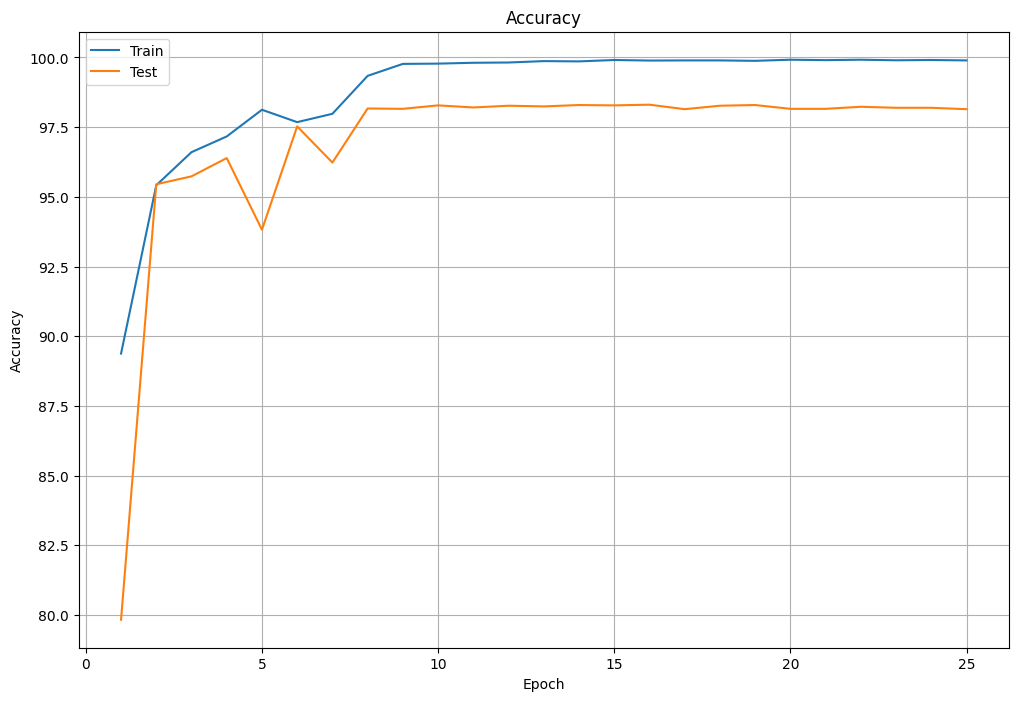

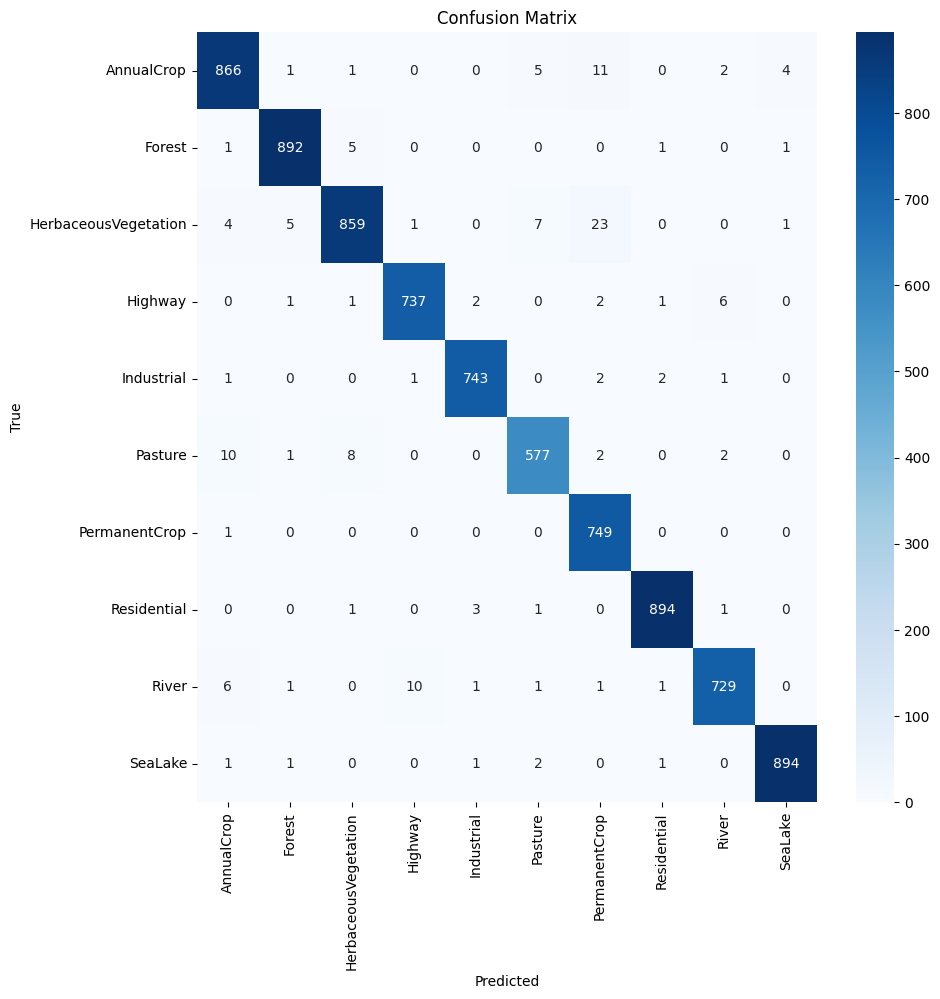

In [9]:
# Training and evaluation loop
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
epochs = []

total_train_time = 0.0
total_inference_time = 0.0

for epoch in range(1, NUM_EPOCHS + 1):
    print(f'\n\nRunning epoch {epoch} of {NUM_EPOCHS}...\n')
    epochs.append(epoch)

    # Timing for training
    start_time = time.time()

    # -------------------------Train-------------------------
    correct = 0
    iterations = 0
    iter_loss = 0.0

    model.train()  # Put the network into training mode

    for i, (inputs, labels) in enumerate(train_loader):
        if USE_CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = model(inputs)#.logits
        loss = criterion(outputs, labels)
        iter_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        iterations += 1

    scheduler.step()

    train_loss.append(iter_loss / iterations)
    train_accuracy.append(100.0 * correct / len(train_dataset))

    # End timing for training
    end_time = time.time()
    epoch_train_time = end_time - start_time
    total_train_time += epoch_train_time

    # -------------------------Test--------------------------
    # Timing for inference
    start_time = time.time()

    correct = 0
    iterations = 0
    testing_loss = 0.0
    all_preds = []
    all_labels = []

    model.eval()  # Put the network into evaluation mode

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in test_loader:
            if USE_CUDA:
                inputs = inputs.cuda()
                labels = labels.cuda()

            outputs = model(inputs)#.logits
            loss = criterion(outputs, labels)
            testing_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            iterations += 1

    test_loss.append(testing_loss / iterations)
    test_accuracy.append(100.0 * correct / len(test_dataset))

    # End timing for inference
    end_time = time.time()
    epoch_inference_time = end_time - start_time
    total_inference_time += epoch_inference_time

    print(f'\nEpoch {epoch} validation results: Loss={test_loss[-1]} | Accuracy={test_accuracy[-1]}\n')

    # Print total training and inference times
    print(f'\nTotal Training Time: {total_train_time} seconds')
    print(f'Total Inference Time: {total_inference_time} seconds')

    plt.figure(figsize=(12, 8), num=1)
    plt.clf()
    plt.plot(epochs, train_loss, label='Train')
    plt.plot(epochs, test_loss, label='Test')
    plt.legend()
    plt.grid()
    plt.title('Cross entropy loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig('outputs/01-loss-EfficientViT_M2_4db.pdf')

    plt.figure(figsize=(12, 8), num=2)
    plt.clf()
    plt.plot(epochs, [acc.cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in train_accuracy], label='Train')
    plt.plot(epochs, [acc.cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in test_accuracy], label='Test')
    plt.legend()
    plt.grid()
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.savefig('outputs/02-accuracy-EfficientViT_M2_4db.pdf')

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('outputs/03-confusion-EfficientViT_M2_4db.pdf')
plt.show()

In [10]:
print(f'Final train loss: {train_loss[-1]}')
print(f'Final test loss: {test_loss[-1]}')
print(f'Final train accuracy: {train_accuracy[-1]}')
print(f'Final test accuracy: {test_accuracy[-1]}')

Final train loss: 0.004279709659675492
Final test loss: 0.08159748152243047
Final train accuracy: 99.89526184538653
Final test accuracy: 98.14585908529048


In [11]:
# Define the path where the entire model will be saved
model_path = './outputs/EfficientViT_M2_4db.pth'

# Save the entire model
torch.save(model.state_dict(), model_path)
print(f"Entire model saved to {model_path}")

Entire model saved to ./outputs/EfficientViT_M2_4db.pth


In [12]:
# Load pre-trained model for inference
from classification.model.build import EfficientViT_M2
loaded_model = EfficientViT_M2(pretrained='efficientvit_m2')

# Modify the classifier to match the number of classes
loaded_model.head.l = nn.Linear(model.head.l.in_features, len(class_names))



# Load the state dictionary
loaded_model.load_state_dict(torch.load(model_path))

if USE_CUDA:
    loaded_model = loaded_model.cuda()

print('Model loaded and ready for inference')

Model loaded and ready for inference


/tmp/ipykernel_622708/300368777.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_path))



Loaded model test results: Loss=0.08159748152243047 | Accuracy=98.14585908529048
Precision: 0.9816180888699021 | Recall: 0.9814585908529048
Inference Time for Loaded Model: 6.254466772079468 seconds



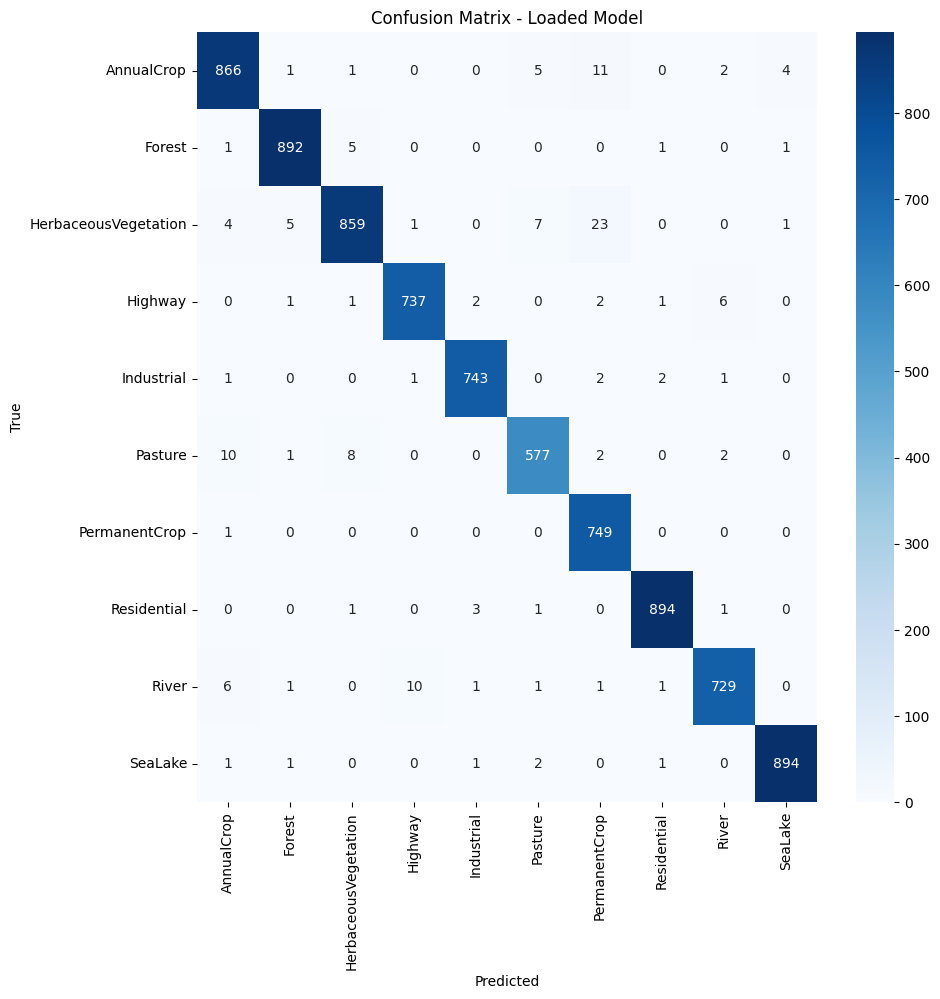

In [13]:
# Test the loaded model
loaded_model.eval()  # Put the network into evaluation mode

correct = 0
iterations = 0
testing_loss = 0.0
all_preds = []
all_labels = []

# Timing for inference of the loaded model
start_time = time.time()

with torch.no_grad():  # Disable gradient calculation
    for inputs, labels in test_loader:
        if USE_CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = loaded_model(inputs)#.logits
        loss = criterion(outputs, labels)
        testing_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        iterations += 1

# End timing for inference of the loaded model
end_time = time.time()
loaded_model_inference_time = end_time - start_time

test_loss_final = testing_loss / iterations
test_accuracy_final = 100.0 * correct / len(test_dataset)
precision_final = precision_score(all_labels, all_preds, average='weighted')
recall_final = recall_score(all_labels, all_preds, average='weighted')

print(f'\nLoaded model test results: Loss={test_loss_final} | Accuracy={test_accuracy_final}')
print(f'Precision: {precision_final} | Recall: {recall_final}')
print(f'Inference Time for Loaded Model: {loaded_model_inference_time} seconds\n')

# Confusion matrix for loaded model
conf_matrix_final = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix_final, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Loaded Model')
#plt.savefig('outputs/04-confusion-matrix_loaded_xLSTM.pdf')
plt.show()